# Laboratorium 6 - rekomendacje oparte na grafach wiedzy

## Przygotowanie

 * pobierz i wypakuj dataset: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge
   * na potrzeby drugiej części laboratorium (czyli testowego treningu), na Teamsach macie dostępny podzbiór danych, `a_few_playlists_dataset` - nie wystarczy on jednak do wykonania trzeciej części (i tym samym do oddania laboratorium)
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install numpy pandas pykeen tqdm seaborn`

## Część 1. - przygotowanie danych

In [10]:
!unzip spotify_50k_playlist_dataset.zip

Archive:  spotify_50k_playlist_dataset.zip
replace spotify_50k_playlist_dataset/filenames.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!pip install numpy pandas pykeen tqdm seaborn

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from pykeen.models import TransE
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [15]:
# konfiguracja datasetu Spotify
PATH = 'spotify_50k_playlist_dataset'
SAMPLING_RATIO = 1.0
with open(f"{PATH}/filenames.txt") as fn:
    FILENAMES = fn.read().split('\n')

In [16]:
# funkcje do parsowania playlist
def get_id(uri):
    return uri.split(':')[-1]

def parse_playlist(playlist):
    name = playlist['name']
    tracks = [get_id(t['track_uri']) for t in playlist['tracks']]
    tracks_to_artists = {(get_id(t['track_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    tracks_to_albums = {(get_id(t['track_uri']), get_id(t['album_uri'])) for t in playlist['tracks']}
    albums_to_artists = {(get_id(t['album_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    return name, tracks, tracks_to_artists, tracks_to_albums, albums_to_artists

In [17]:
# parsing
playlists = []
tracks = set()
tracks_to_artists = set()
tracks_to_albums = set()
albums_to_artists = set()

for filename in tqdm(FILENAMES):
    with open(f'{PATH}/{filename}') as mpd_chunk:
        for playlist in json.loads(mpd_chunk.read())['playlists']:
            a, b, c, d, e = parse_playlist(playlist)
            playlists.append(b)
            tracks.update(set(b))
            tracks_to_artists.update(c)
            tracks_to_albums.update(d)
            albums_to_artists.update(e)

print(f'Got: {len(playlists):,} playlists; {len(tracks):,} tracks; {len({x[1] for x in tracks_to_albums}):,} albums; {len({x[1] for x in tracks_to_artists}):,} artists')

100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Got: 50,000 playlists; 463,812 tracks; 194,206 albums; 78,982 artists


In [18]:
# w zbiorze testowym chcemy tylko te playlisty, ktorych wszystkie piosenki wystapia takze choc raz w zbiorze treningowym
tracks_counter = {}
for p in tqdm(playlists):
    for t in p:
        if t in tracks_counter:
            tracks_counter[t] += 1
        else:
            tracks_counter[t] = 1

playlists_with_only_non_unique_tracks = []
for i in tqdm(range(len((playlists)))):
    p = playlists[i]
    if all([tracks_counter[t] > 1 for t in p]):
        playlists_with_only_non_unique_tracks.append(i)

# zbior testowy to 1/10 wszystkich playlist - czyli 100k, jesli nie używamy samplingu
test_playlist_ids = random.sample(playlists_with_only_non_unique_tracks, int(SAMPLING_RATIO*5_000))
# zbior treningowy to cala reszta playlist - jest ich duzo, wiec sprobujmy to zrobic wydajnie
test_ids_sorted = sorted(test_playlist_ids)
test_i = 0
train_playlist_ids = []
i = 0
while i < len(playlists):
    if test_i < len(test_ids_sorted) and test_ids_sorted[test_i] == i:
        test_i += 1
    else:
        train_playlist_ids.append(i)
    i += 1

train_playlists = [playlists[i] for i in train_playlist_ids]
test_playlists = [playlists[i] for i in test_playlist_ids]

print(f'train dataset: {len(train_playlists):,}; test dataset: {len(test_playlists):,}')

100%|██████████| 50000/50000 [00:01<00:00, 37384.65it/s]

train dataset: 45,000; test dataset: 5,000


## Część 2. - budowa i ewaluacja modelu

### Relacje istniejące w naszym datasecie:
![poglądowy obrazek relacji w datasecie](relations.svg)

In [19]:
# budowanie zbioru relacji
# mozesz usunac czesc wpisow z listy `relations`
relations = ['follows', 'authored_by', 'in_album', 'authored']
triples = []

# relacje piosenka -> autor
if 'authored_by' in relations:
    for track, artist in tqdm(tracks_to_artists):
        triples.append((track, 'authored_by', artist))

# relacje piosenka -> artysta
if 'in_album' in relations:
    for track, album in tqdm(tracks_to_albums):
        triples.append((track, 'in_album', album))

# relacje artysta -> album
if 'authored' in relations:
    for album, artist in tqdm(albums_to_artists):
        triples.append((artist, 'authored', album))

# relacje piosenka -> piosenka
if 'follows' in relations:
    for playlist in tqdm(train_playlists):
        for i in range(len(playlist)-1):
            triples.append((playlist[i], 'follows', playlist[i+1]))

num_entities = len(triples)
num_relations = len(relations)

print(f'Got {num_relations} relations with total of {num_entities:,} entries')

100%|██████████| 45000/45000 [00:01<00:00, 39738.72it/s]

Got 4 relations with total of 4,164,371 entries


In [20]:
# trening
tf = TriplesFactory.from_labeled_triples(np.array(triples))
# ta dysproporcja jest po to, by szybko uzyskac jakikolwiek wynik
#   - dla uzyskania sensownych wynikow warto zmienic split na np. standardowe 80-10-10
training, testing, validation = tf.split([.8, .1, .1])

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2238482, 362660, 362661]


In [ ]:
pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransE, # to najszybszy i najprostszy, ale i najgorszy model; pomysl o uzyciu TransH, TransR, RESCAL albo dowolnego innego
    epochs=15 # to zdecydowanie za malo - 1 wystarczy do jakichkolwiek wynikow, 5 do dosc slabych, blizej 20 do sensownych
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2240819, 362815, 362815]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/15 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11338 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=32.


Evaluating on cuda:0:   0%|          | 0.00/363k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2633.44s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

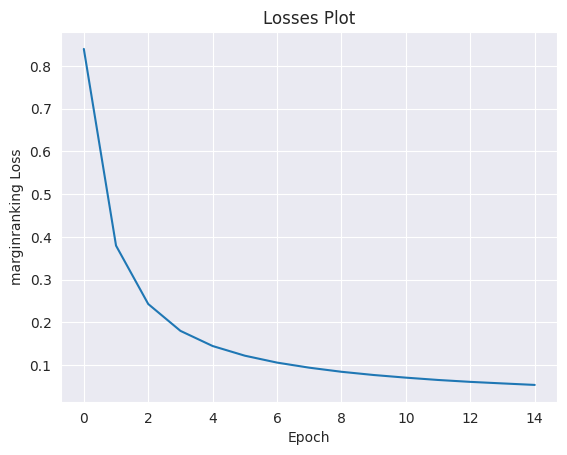

In [ ]:
# zgrubne oszacowanie jakosci wytrenowanego modelu
pipeline_result.plot_losses()

In [21]:
# funkcja zwracajaca predykcje z modelu
def predict_next_tracks(track_id: str, k: int) -> list[str]:
    return predict_target(
        model=pipeline_result.model,
        head=track_id,
        relation="follows",
        triples_factory=tf,
    ).df.nlargest(k, "score")["tail_label"].tolist()

In [22]:
# metryki do porownania rekomenderow - precision@k i recall@k
def precision(prediction: list[str], actual_tracks: list[str]) -> float:
    return len(set(prediction) & set(actual_tracks)) / len(prediction)

def recall(prediction: list[str], actual_tracks: list[str]) -> float:
    return len(set(prediction) & set(actual_tracks)) / len(actual_tracks)

In [23]:
def grade_model():
    for playlist in sample_playlists:
      last_track = playlist[cutoff_idx]
      actual_tracks = playlist[cutoff_idx+1:]
      prediction = predict_next_tracks(last_track, k)
      precisions.append(precision(prediction, actual_tracks))
      recalls.append(recall(prediction, actual_tracks))

    # histogram z wynikami
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(precisions, bins=20)
    ax1.set_title('Precision')
    ax2.hist(recalls, bins=20)
    ax2.set_title('Recall')
    plt.show()

In [24]:
# ocena wynikow

# odsiewamy playlisty zbyt krotkie, by dac sensowne wyniki
long_enough_test_playlists = [p for p in test_playlists if len(p) >= 10]
# z kazdej playlisty, elementy od 0 do `cutoff_idx` wlacznie sa dane, na ich podstawie robimy predykcje
# elementy od cutoff_idx+1 do konca powinnismy umiec przewidziec
cutoff_idx = 4
# ile elementow ma przewidziec nasz model
k = 20
precisions: list[float] = []
recalls: list[float] = []

# calculating for over 4k playlists is horribly slow
sample_playlists = random.sample(long_enough_test_playlists, 1000)

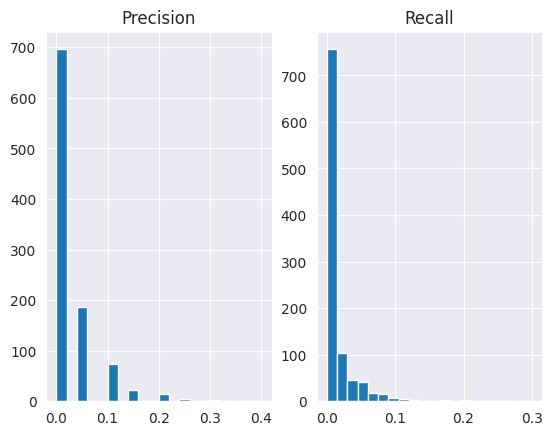

In [ ]:
grade_model()

## Część 3. - porównanie różnych metod rekomendacji

W części 2. zbudowaliśmy zbiór trójek relacji, wytrenowaliśmy jeden model, zaimplementowaliśmy (prostą) metodę generującą rekomendacje na podstawie predykcji modelu i w końcu zaimplementowaliśmy dwie metryki do porównania jakości tych rekomendacji.

W części 3. Twoim zadaniem jest przetestować trzy różne podejścia do jednego z kroków:
1. Porównaj trzy różne modele spośród dostępnych w bibliotece PyKeen: https://pykeen.readthedocs.io/en/stable/reference/models.html#classes
   * jeden model translacyjny (np. TransE, TransH, TransR)
   * jeden model faktoryzacyjny (np. RESCAL)
   * jeden dowolny model niewybrany w poprzednich punktach
2. Porównaj trzy metody budowania grafu wiedzy:
   * graf zawierający relacje wszystkich czterech typów
   * graf zawierający tylko relacje typu `follows` (czyli między kolejnymi utworami w playliście)
   * graf zawierający relacje wybranych przez Ciebie dwóch lub trzech typów (czyli krok pośredni między powyższymi punktami)
3. Porównaj trzy metody generowania rekomendacji na podstawie elementów zwróconych przez `predict_target()` (ta metoda zwraca m. in. score'y każdego z proponowanych elementów, co może okazać się pomocne):
   * metoda opierająca się tylko na predykcji dla ostatniego znanego elementu w playliście
   * dwie wymyślone przez Ciebie, bardziej zaawansowane metody
  
Niezależnie od tego, który z trzech powyższych scenariuszy wybierzesz - porównaj trzy wybrane przez Ciebie metody na podstawie histogramów metryk `precision@k` i `recall@k`.

In [25]:
from pykeen.models import TransR, RESCAL, PairRE

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/8 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=16.


Evaluating on cuda:0:   0%|          | 0.00/363k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8111.58s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

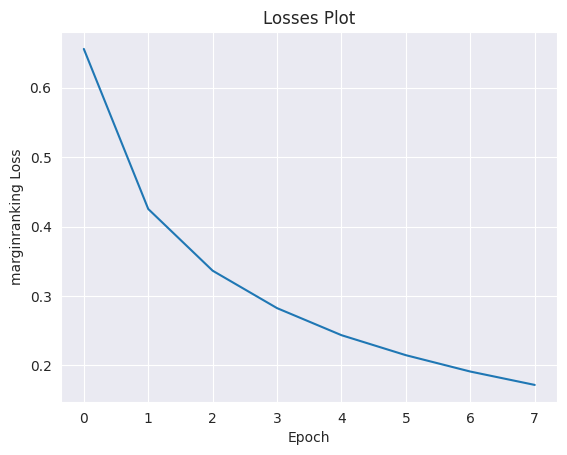

In [27]:
pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransR,
    epochs=8
)

pipeline_result.plot_losses()

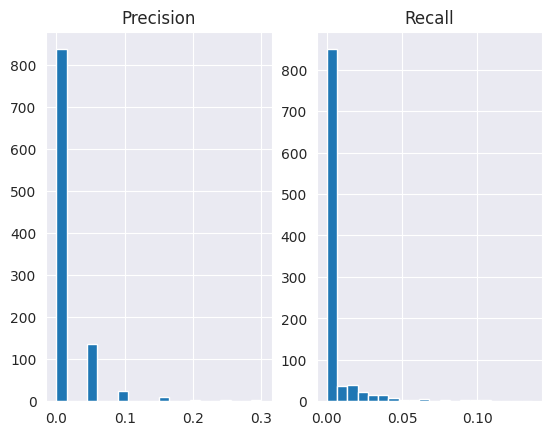

In [29]:
grade_model()

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cuda:0:   0%|          | 0/8 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/11334 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


Evaluating on cuda:0:   0%|          | 0.00/363k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1547.93s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

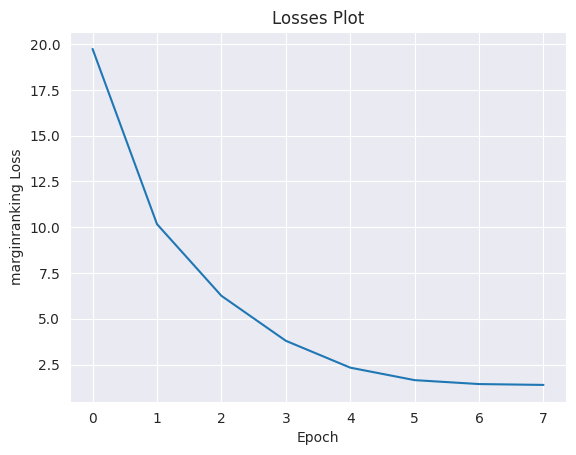

In [30]:
pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RESCAL,
    epochs=8
)

pipeline_result.plot_losses()

In [ ]:
grade_model()

In [ ]:
pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=PairRE,
    epochs=15
)

In [ ]:
grade_model()